In [1]:
import warnings
warnings.filterwarnings('ignore')

import multiprocessing
n_cores = multiprocessing.cpu_count()

import sys
import os
import copy 

sys.path.insert(1, os.path.realpath(os.path.pardir))
sys.path.append("../node2vec2rank/")


import pandas as pd
import numpy as np

In [12]:
## experiment info that will be used for folder names and printing

tissue = 'LUAD'
target = 'mVSf'
network_inf_method = 'WGCNA'
gsea_exp_parent_folder_name = 'WGCNA_LUAD_mVSf_final'
save_gsea_results_notes = ''

In [3]:
# read the configuration file and the data
from node2vec2rank.dataloader import DataLoader
import json

config = json.load(open('../configs/config_wgcna_LUAD_mf.json', 'r'))

config = {param: value for section, params in config.items()
          for param, value in params.items()}

In [4]:
#load the data
dataloader = DataLoader(config)

There are 26000 row nodes and 26000 column nodes in graph 1
There are 26000 row nodes and 26000 column nodes in graph 2


In [5]:
# #plot the edge value histograms


# import matplotlib.pyplot as plt


# first_flat = dataloader.graphs[0].to_numpy().flatten()
# second_flat = dataloader.graphs[1].to_numpy().flatten()

# plt.hist(first_flat,log=True,bins=100);
# plt.hist(second_flat,log=True,bins=100);

In [6]:
# plt.hist(second_flat,log=True,bins=100);
# plt.hist(first_flat,log=True,bins=100);

In [7]:
# del first_flat, second_flat

In [8]:
#run n2v2r


from node2vec2rank.model import N2V2R

model = N2V2R(graphs=dataloader.graphs, config=config, node_names=dataloader.interest_nodes)
rankings = model.fit_transform_rank()

DeDi_ranking = model.degree_difference_ranking()
borda_rankings = model.aggregate_transform()

signed_rankings = model.signed_ranks_transform()

../output/12_18_2023_16_07_44

Running n2v2r with dimensions [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24] and distance metrics ['euclidean', 'cosine'] ...


	UASE embedding in 11.59 seconds for bin=False and keep_top=100%
		Ranking in 8.8 seconds
n2v2r computed 22 rankings for 1 comparison(s) in 66.5 seconds

Rank aggregation with Borda ...
	Finished aggregation in 9.29 seconds

Signed ranks transformation ...
	Finished signed transformation in 5.47 seconds


In [9]:
##get the rankings of the comparison and map the ens to symbols

comparison = '1'
n2v2r_ranking_pd = rankings[comparison].copy()
n2v2r_borda_ranking_pd = borda_rankings[comparison].copy()
n2v2r_DeDi_ranking_pd = signed_rankings[comparison].copy()
n2v2r_borda_DeDi_ranking_pd = model.pairwise_signed_aggregate_ranks[comparison].copy()
DeDi_ranking_pd = DeDi_ranking[comparison].copy()

gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}
genes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in dataloader.interest_nodes ]

n2v2r_ranking_pd.index = genes_mapped
n2v2r_borda_ranking_pd.index = genes_mapped
n2v2r_DeDi_ranking_pd.index = genes_mapped
n2v2r_borda_DeDi_ranking_pd.index = genes_mapped
DeDi_ranking_pd.index = genes_mapped


In [10]:
# # check nDCG score for some set of genes for n2v2r (borda) ranking
# # higher scores means that a method is ranking higher the sex biased genes

# from node2vec2rank.post_utils import read_gmt, normalized_discounted_cumulative_gain

# chrX_escapees_fn = '../data/gene_set_libraries/human/chrX_escapees.csv'
# gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'

# gencode = pd.read_csv(gencode_fn, index_col=0)
# chrY_genes = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])
# chrX_escapees = set(pd.read_csv(
#     chrX_escapees_fn, sep=",", header=None).iloc[0, :])
# sex_biased_genes = chrY_genes.union(chrX_escapees)

# sorted_n2v2r_ranking_pd = n2v2r_ranking_pd.iloc[:,0].sort_values(ascending=False)
# ranked_nodes_n2v2r = sorted_n2v2r_ranking_pd.index.to_list()

# sorted_n2v2r_borda_ranking_pd = n2v2r_borda_ranking_pd.sort_values(by = 'borda_ranks', ascending=False)
# ranked_nodes_n2v2r_borda = sorted_n2v2r_borda_ranking_pd.index.to_list()

# sorted_DeDi_ranking_pd = DeDi_ranking_pd.sort_values(by = 'absDeDi', ascending=False)
# ranked_nodes_absDeDi = sorted_DeDi_ranking_pd.index.to_list()

# ## chrY
# # which genes should be relevant
# relevance_vector_n2v2r_chrY = [
#     1 if x in chrY_genes else 0 for x in ranked_nodes_n2v2r]
# nDCG_n2v2r_chrY = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_chrY, binary_relevance=True)
# print(f"\nnDCG score for n2v2r and chrY is {round(nDCG_n2v2r_chrY,3)}")

# relevance_vector_n2v2r_borda_hrY = [
#     1 if x in chrY_genes else 0 for x in ranked_nodes_n2v2r_borda]
# nDCG_n2v2r_borda_chrY = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_borda_hrY, binary_relevance=True)
# print(f"nDCG score for n2v2r borda and chrY is {round(nDCG_n2v2r_borda_chrY,3)}")

# relevance_vector_absDeDi_chrY = [
#     1 if x in chrY_genes else 0 for x in ranked_nodes_absDeDi]
# nDCG_absDeDi_chrY = normalized_discounted_cumulative_gain(relevance_vector_absDeDi_chrY, binary_relevance=True)

# print(f"nDCG score for (absolute) DeDi and chrY is {round(nDCG_absDeDi_chrY,3)}")

# ## escapees X
# # which genes should be relevant
# relevance_vector_n2v2r_chrX = [
#     1 if x in chrX_escapees else 0 for x in ranked_nodes_n2v2r]
# nDCG_n2v2r_chrX = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_chrX, binary_relevance=True)
# print(f"\nnDCG score for n2v2r and chrX escapees is {round(nDCG_n2v2r_chrX,3)}")

# relevance_vector_n2v2r_borda_chrX = [
#     1 if x in chrX_escapees else 0 for x in ranked_nodes_n2v2r_borda]
# nDCG_n2v2r_borda_chrX = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_borda_chrX, binary_relevance=True)
# print(f"nDCG score for n2v2r borda and chrX escapees is {round(nDCG_n2v2r_borda_chrX,3)}")

# relevance_vector_absDeDi_chrX = [
#     1 if x in chrX_escapees else 0 for x in ranked_nodes_absDeDi]
# nDCG_absDeDi_chrX = normalized_discounted_cumulative_gain(relevance_vector_absDeDi_chrX, binary_relevance=True)

# print(f"nDCG score for (absolute) DeDi and chrX escapees is {round(nDCG_absDeDi_chrX,3)}")

# # which genes should be relevant
# ## both escapees X and chr Y
# relevance_vector_n2v2r_sex_biased = [
#     1 if x in sex_biased_genes else 0 for x in ranked_nodes_n2v2r]
# nDCG_n2v2r_sex_biased = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_sex_biased, binary_relevance=True)
# print(f"\nnDCG score for n2v2r and chrY + chrX escapees is {round(nDCG_n2v2r_sex_biased,3)}")

# relevance_vector_n2v2r_borda_sex_biased = [
#     1 if x in sex_biased_genes else 0 for x in ranked_nodes_n2v2r_borda]
# nDCG_n2v2r_borda_sex_biased = normalized_discounted_cumulative_gain(relevance_vector_n2v2r_borda_sex_biased, binary_relevance=True)
# print(f"nDCG score for n2v2r borda and chrY + chrX escapees is {round(nDCG_n2v2r_borda_sex_biased,3)}")

# relevance_vector_absDeDi_sex_biased = [
#     1 if x in sex_biased_genes else 0 for x in ranked_nodes_absDeDi]
# nDCG_absDeDi_sex_biased = normalized_discounted_cumulative_gain(relevance_vector_absDeDi_sex_biased, binary_relevance=True)

# print(f"nDCG score for (absolute) DeDi and chrY + chrX escapees is {round(nDCG_absDeDi_sex_biased,3)}")


In [11]:
# remove chrY genes for the analysis


chrY_gene_names = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])

DeDi_data_pd = DeDi_ranking_pd[~DeDi_ranking_pd.index.isin(chrY_gene_names)]

n2v2r_ranking_pd = n2v2r_ranking_pd[~n2v2r_ranking_pd.index.isin(
    chrY_gene_names)]
n2v2r_borda_ranking_pd = n2v2r_borda_ranking_pd[~n2v2r_borda_ranking_pd.index.isin(
    chrY_gene_names)]

n2v2r_DeDi_ranking_pd = n2v2r_DeDi_ranking_pd[~n2v2r_DeDi_ranking_pd.index.isin(
    chrY_gene_names)]
n2v2r_borda_DeDi_ranking_pd = n2v2r_borda_DeDi_ranking_pd[~n2v2r_borda_DeDi_ranking_pd.index.isin(
    chrY_gene_names)]

In [13]:
# run overrepresentation analysis 
from node2vec2rank.post_utils import enrichr_gseapy, read_gmt
from itertools import chain
import os

save_results = True
do_kegg = True
do_gobp = False
do_reac = False
do_immune = False



# read the geneset libraries
kegg_pathway_fn = '../data/gene_set_libraries/human/c2.cp.kegg.v7.5.1.symbols.gmt'
gobp_pathway_fn = '../data/gene_set_libraries/human/c5.go.bp.v7.5.1.symbols.gmt'
reac_pathway_fn = '../data/gene_set_libraries/human/c2.cp.reactome.v7.5.1.symbols.gmt'
immune_pathway_fn = '../data/gene_set_libraries/human/c7.immunesigdb.v7.5.1.symbols.gmt'



# network_background or pathway_background for enrichment
# network will use the genes in the network only, while pathway will use all the genes in the pathways
# network is "more fair" but will find less things in small networks
background = 'network_background'
organism = 'human'

# take the top k percentage of the ranking for enrichment
top_k_percent = 2

if background == 'network_background':
    kegg_background = n2v2r_ranking_pd.index.to_list()
    gobp_background = n2v2r_ranking_pd.index.to_list()
    reac_background = n2v2r_ranking_pd.index.to_list()
    immune_background = n2v2r_ranking_pd.index.to_list()
elif background == 'pathway_background':
    kegg_dict = read_gmt(kegg_pathway_fn)
    kegg_background = list(set(chain.from_iterable(kegg_dict.values())))
    gobp_dict = read_gmt(gobp_pathway_fn)
    gobp_background = list(set(chain.from_iterable(gobp_dict.values())))
    reac_dict = read_gmt(reac_pathway_fn)
    reac_background = list(set(chain.from_iterable(reac_dict.values())))
    immune_dict = read_gmt(immune_pathway_fn)
    immune_background = list(set(chain.from_iterable(immune_dict.values())))
else:
    raise Exception("Enrichment background not properly set")


if do_kegg:
    n2v2r_consensus_ORA_KEGG_pd = enrichr_gseapy(n2v2r_ranking_pd, kegg_pathway_fn, background=kegg_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    n2v2r_borda_ORA_KEGG_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, background=kegg_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    absDeDi_ORA_KEGG_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], kegg_pathway_fn, background=kegg_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

if do_gobp:
    n2v2r_consensus_ORA_GOBP_pd = enrichr_gseapy(n2v2r_ranking_pd, gobp_pathway_fn, background=gobp_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    n2v2r_borda_ORA_GOBP_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    absDeDi_ORA_GOBP_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], gobp_pathway_fn, background=gobp_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

if do_reac:
    n2v2r_consensus_ORA_REAC_pd = enrichr_gseapy(n2v2r_ranking_pd, reac_pathway_fn, background=reac_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    n2v2r_borda_ORA_REAC_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, reac_pathway_fn, background=reac_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    absDeDi_ORA_REAC_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], reac_pathway_fn, background=reac_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)

if do_immune:
    n2v2r_consensus_ORA_IMMUNE_pd = enrichr_gseapy(n2v2r_ranking_pd, immune_pathway_fn, background=immune_background,enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    n2v2r_borda_ORA_IMMUNE_pd = enrichr_gseapy(n2v2r_borda_ranking_pd, immune_pathway_fn, background=immune_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)
    absDeDi_ORA_IMMUNE_pd = enrichr_gseapy(DeDi_ranking_pd.iloc[:,[1]], immune_pathway_fn, background=immune_background, enrich_quantile_cutoff=1-top_k_percent/100, organism=organism)


if save_results:
    path = '../results/results_gsea/' + gsea_exp_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    if do_kegg:
        n2v2r_consensus_ORA_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                       "_n2v2r"+"_consensus_ORA_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_ORA_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r_borda_ORA_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_ORA_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_ORA_KEGG_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    if do_gobp:
        n2v2r_consensus_ORA_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                       "_n2v2r"+"_consensus_ORA_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_ORA_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+ 
                             "_n2v2r_borda_ORA_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_ORA_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_ORA_GOBP_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    if do_reac:
        n2v2r_consensus_ORA_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                        "_n2v2r"+"_consensus_ORA_REAC_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_ORA_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+ 
                                "_n2v2r_borda_ORA_REAC_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')                        
        absDeDi_ORA_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                "_absDeDi"+"_ORA_REAC_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    if do_immune:
        n2v2r_consensus_ORA_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                        "_n2v2r"+"_consensus_ORA_IMMUNE_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_ORA_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+ 
                                "_n2v2r_borda_ORA_IMMUNE_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')                        
        absDeDi_ORA_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                "_absDeDi"+"_ORA_IMMUNE_"+background+"_top"+str(top_k_percent)+"_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')



In [13]:
from node2vec2rank.post_utils import plot_gseapy_enrich 

stability_cutoff = 0
padj_cutoff = 0.1




save_directory = '../results/results_gsea/' + gsea_exp_parent_folder_name
# save_directory = None

if do_kegg:
    title = network_inf_method+ " " +  tissue +  " KEGG ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)
    to_bold_from_dedi=plot_gseapy_enrich(absDeDi_ORA_KEGG_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=5, has_stability=False, stability_cutoff=stability_cutoff, plot=False)['pathway'].values
    to_bold_from_n2v2r_borda=plot_gseapy_enrich(n2v2r_borda_ORA_KEGG_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=5, has_stability=False, stability_cutoff=stability_cutoff, plot=False)['pathway'].values

    plot_gseapy_enrich(absDeDi_ORA_KEGG_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=5, has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda)


    plot_gseapy_enrich(n2v2r_consensus_ORA_KEGG_pd, has_stability=True, trim_first_num_characters=5, characters_trim=40, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory,to_bold=to_bold_from_dedi)
    plot_gseapy_enrich(n2v2r_borda_ORA_KEGG_pd, padj_cutoff=padj_cutoff,characters_trim=40, trim_first_num_characters=5,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory,to_bold=to_bold_from_dedi)



if do_gobp:
    title = network_inf_method+ " " +  tissue +  " GOBP ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

    to_bold_from_dedi=plot_gseapy_enrich(absDeDi_ORA_GOBP_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=5, has_stability=False, stability_cutoff=stability_cutoff, plot=False)['pathway'].values
    to_bold_from_n2v2r_borda=plot_gseapy_enrich(n2v2r_borda_ORA_GOBP_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=5, has_stability=False, stability_cutoff=stability_cutoff, plot=False)['pathway'].values

    plot_gseapy_enrich(absDeDi_ORA_GOBP_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=5, has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda)


    plot_gseapy_enrich(n2v2r_consensus_ORA_GOBP_pd, has_stability=True, trim_first_num_characters=5, characters_trim=40, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory,to_bold=to_bold_from_dedi)
    plot_gseapy_enrich(n2v2r_borda_ORA_GOBP_pd, padj_cutoff=padj_cutoff,characters_trim=40, trim_first_num_characters=5,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory,to_bold=to_bold_from_dedi)

if do_reac:
    title = network_inf_method+ " " +  tissue +  " REAC ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

    to_bold_from_dedi=plot_gseapy_enrich(absDeDi_ORA_REAC_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=9, has_stability=False, stability_cutoff=stability_cutoff, plot=False)['pathway'].values
    to_bold_from_n2v2r_borda=plot_gseapy_enrich(n2v2r_borda_ORA_REAC_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=9, has_stability=False, stability_cutoff=stability_cutoff, plot=False)['pathway'].values

    plot_gseapy_enrich(absDeDi_ORA_REAC_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=9, has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda)


    plot_gseapy_enrich(n2v2r_consensus_ORA_REAC_pd, has_stability=True, trim_first_num_characters=9, characters_trim=40, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory,to_bold=to_bold_from_dedi)
    plot_gseapy_enrich(n2v2r_borda_ORA_REAC_pd, padj_cutoff=padj_cutoff,characters_trim=40, trim_first_num_characters=9,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory,to_bold=to_bold_from_dedi)

if do_immune:

    title = network_inf_method+ " " +  tissue +  " IMMUNE ORA " + target + " padj " + str(padj_cutoff) + " " +background + " top " + str(top_k_percent) + " stab " + str(stability_cutoff)

    to_bold_from_dedi=plot_gseapy_enrich(absDeDi_ORA_IMMUNE_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=9, has_stability=False, stability_cutoff=stability_cutoff, plot=False)['pathway'].values
    to_bold_from_n2v2r_borda=plot_gseapy_enrich(n2v2r_borda_ORA_IMMUNE_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=9, has_stability=False, stability_cutoff=stability_cutoff, plot=False)['pathway'].values

    plot_gseapy_enrich(absDeDi_ORA_IMMUNE_pd, padj_cutoff=padj_cutoff,characters_trim=40,trim_first_num_characters=9, has_stability=False, stability_cutoff=stability_cutoff, title="absDeDi " + title,output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda)


    plot_gseapy_enrich(n2v2r_consensus_ORA_IMMUNE_pd, has_stability=True, trim_first_num_characters=9, characters_trim=40, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff,  title="n2v2r cons. " + title,output_dir=save_directory,to_bold=to_bold_from_dedi)
    plot_gseapy_enrich(n2v2r_borda_ORA_IMMUNE_pd, padj_cutoff=padj_cutoff,characters_trim=40, trim_first_num_characters=9,has_stability=False, stability_cutoff=stability_cutoff, title="n2v2r borda " + title,output_dir=save_directory,to_bold=to_bold_from_dedi)



In [ ]:
# run prerank GSEA
from node2vec2rank.post_utils import prerank_gseapy

save_results = True
do_kegg = True
do_gobp = False
do_reac = False
do_immune = False



# read the geneset libraries
kegg_pathway_fn = '../data/gene_set_libraries/human/c2.cp.kegg.v7.5.1.symbols.gmt'
gobp_pathway_fn = '../data/gene_set_libraries/human/c5.go.bp.v7.5.1.symbols.gmt'
reac_pathway_fn = '../data/gene_set_libraries/human/c2.cp.reactome.v7.5.1.symbols.gmt'
immune_pathway_fn = '../data/gene_set_libraries/human/c7.immunesigdb.v7.5.1.symbols.gmt'


prerank_weight = 0
prerank_min_path_size = 5
prerank_max_path_size = 1500
prerank_num_perms = 1500

if do_kegg:
    n2v2r_consensus_pre_KEGG_pd = prerank_gseapy(n2v2r_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    n2v2r_borda_pre_KEGG_pd = prerank_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    absDeDi_pre_KEGG_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], kegg_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_gobp:
    n2v2r_consensus_pre_GOBP_pd = prerank_gseapy(n2v2r_ranking_pd, gobp_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    n2v2r_borda_pre_GOBP_pd = prerank_gseapy(n2v2r_borda_ranking_pd, gobp_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    absDeDi_pre_GOBP_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], gobp_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_reac:
    n2v2r_consensus_pre_REAC_pd = prerank_gseapy(n2v2r_ranking_pd, reac_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    n2v2r_borda_pre_REAC_pd = prerank_gseapy(n2v2r_borda_ranking_pd, reac_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    absDeDi_pre_REAC_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], reac_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_immune:
    n2v2r_consensus_pre_IMMUNE_pd = prerank_gseapy(n2v2r_ranking_pd, immune_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    n2v2r_borda_pre_IMMUNE_pd = prerank_gseapy(n2v2r_borda_ranking_pd, immune_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    absDeDi_pre_IMMUNE_pd = prerank_gseapy(DeDi_ranking_pd.iloc[:,[1]], immune_pathway_fn, prerank_weight=prerank_weight,
                                   prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

if save_results:
    path = '../results/results_gsea/' + gsea_exp_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)


    if do_kegg:
        n2v2r_consensus_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                "_n2v2r"+"_consensus_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
        n2v2r_borda_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
        absDeDi_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

    if do_gobp:
        n2v2r_consensus_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    if do_reac:
        n2v2r_consensus_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        

    if do_immune:
        n2v2r_consensus_pre_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_n2v2r"+"_consensus_prerank_IMMUNE_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        n2v2r_borda_pre_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r" +
                             "_n2v2r_borda_prerank_IMMUNE_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        absDeDi_pre_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                               "_absDeDi"+"_prerank_IMMUNE_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')


    
   

In [15]:
from node2vec2rank.post_utils import plot_gseapy_prerank 

stability_cutoff = 0
padj_cutoff = 0.1

save_directory = '../results/results_gsea/' + gsea_exp_parent_folder_name

if do_kegg:
    title = network_inf_method+ " " +  tissue +  " KEGG prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    to_bold_from_dedi=plot_gseapy_prerank(absDeDi_pre_KEGG_pd, has_stability=False, characters_trim=40, trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, plot=False)['pathway'].values
    to_bold_from_n2v2r_borda=plot_gseapy_prerank(n2v2r_borda_pre_KEGG_pd, has_stability=False, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, output_dir=save_directory,plot=False)['pathway'].values


    plot_gseapy_prerank(absDeDi_pre_KEGG_pd, has_stability=False, characters_trim=40, trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " +title, output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda)

    plot_gseapy_prerank(n2v2r_consensus_pre_KEGG_pd, has_stability=True, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r cons. " +title, output_dir=save_directory,to_bold=to_bold_from_dedi)
    plot_gseapy_prerank(n2v2r_borda_pre_KEGG_pd, has_stability=False, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " +title, output_dir=save_directory,to_bold=to_bold_from_dedi)

if do_gobp:
    title = network_inf_method+ " " +  tissue +  " GOBP prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    to_bold_from_dedi=plot_gseapy_prerank(absDeDi_pre_GOBP_pd, has_stability=False, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, plot=False)['pathway'].values
    to_bold_from_n2v2r_borda=plot_gseapy_prerank(n2v2r_borda_pre_GOBP_pd, has_stability=False, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, output_dir=save_directory,plot=False)['pathway'].values


    plot_gseapy_prerank(absDeDi_pre_GOBP_pd, has_stability=False, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " +title, output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda)

    plot_gseapy_prerank(n2v2r_consensus_pre_GOBP_pd, has_stability=True, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r cons. " +title, output_dir=save_directory,to_bold=to_bold_from_dedi)
    plot_gseapy_prerank(n2v2r_borda_pre_GOBP_pd, has_stability=False, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " +title, output_dir=save_directory,to_bold=to_bold_from_dedi)

if do_reac:
    title = network_inf_method+ " " +  tissue +  " REAC prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    to_bold_from_dedi=plot_gseapy_prerank(absDeDi_pre_REAC_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, plot=False)['pathway'].values
    to_bold_from_n2v2r_borda=plot_gseapy_prerank(n2v2r_borda_pre_REAC_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, output_dir=save_directory,plot=False)['pathway'].values


    plot_gseapy_prerank(absDeDi_pre_REAC_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " +title, output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda)

    plot_gseapy_prerank(n2v2r_consensus_pre_REAC_pd, has_stability=True, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r cons. " +title, output_dir=save_directory,to_bold=to_bold_from_dedi)
    plot_gseapy_prerank(n2v2r_borda_pre_REAC_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " +title, output_dir=save_directory,to_bold=to_bold_from_dedi)

if do_immune:
    title = network_inf_method+ " " +  tissue +  " IMMUNE prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    to_bold_from_dedi=plot_gseapy_prerank(absDeDi_pre_IMMUNE_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, plot=False)['pathway'].values
    to_bold_from_n2v2r_borda=plot_gseapy_prerank(n2v2r_borda_pre_IMMUNE_pd, has_stability=False,trim_first_num_characters=9, characters_trim=40, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, output_dir=save_directory,plot=False)['pathway'].values


    plot_gseapy_prerank(absDeDi_pre_IMMUNE_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="absDeDi " +title, output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda)

    plot_gseapy_prerank(n2v2r_consensus_pre_IMMUNE_pd, has_stability=True, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r cons. " +title, output_dir=save_directory,to_bold=to_bold_from_dedi)
    plot_gseapy_prerank(n2v2r_borda_pre_IMMUNE_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="n2v2r borda " +title, output_dir=save_directory,to_bold=to_bold_from_dedi)


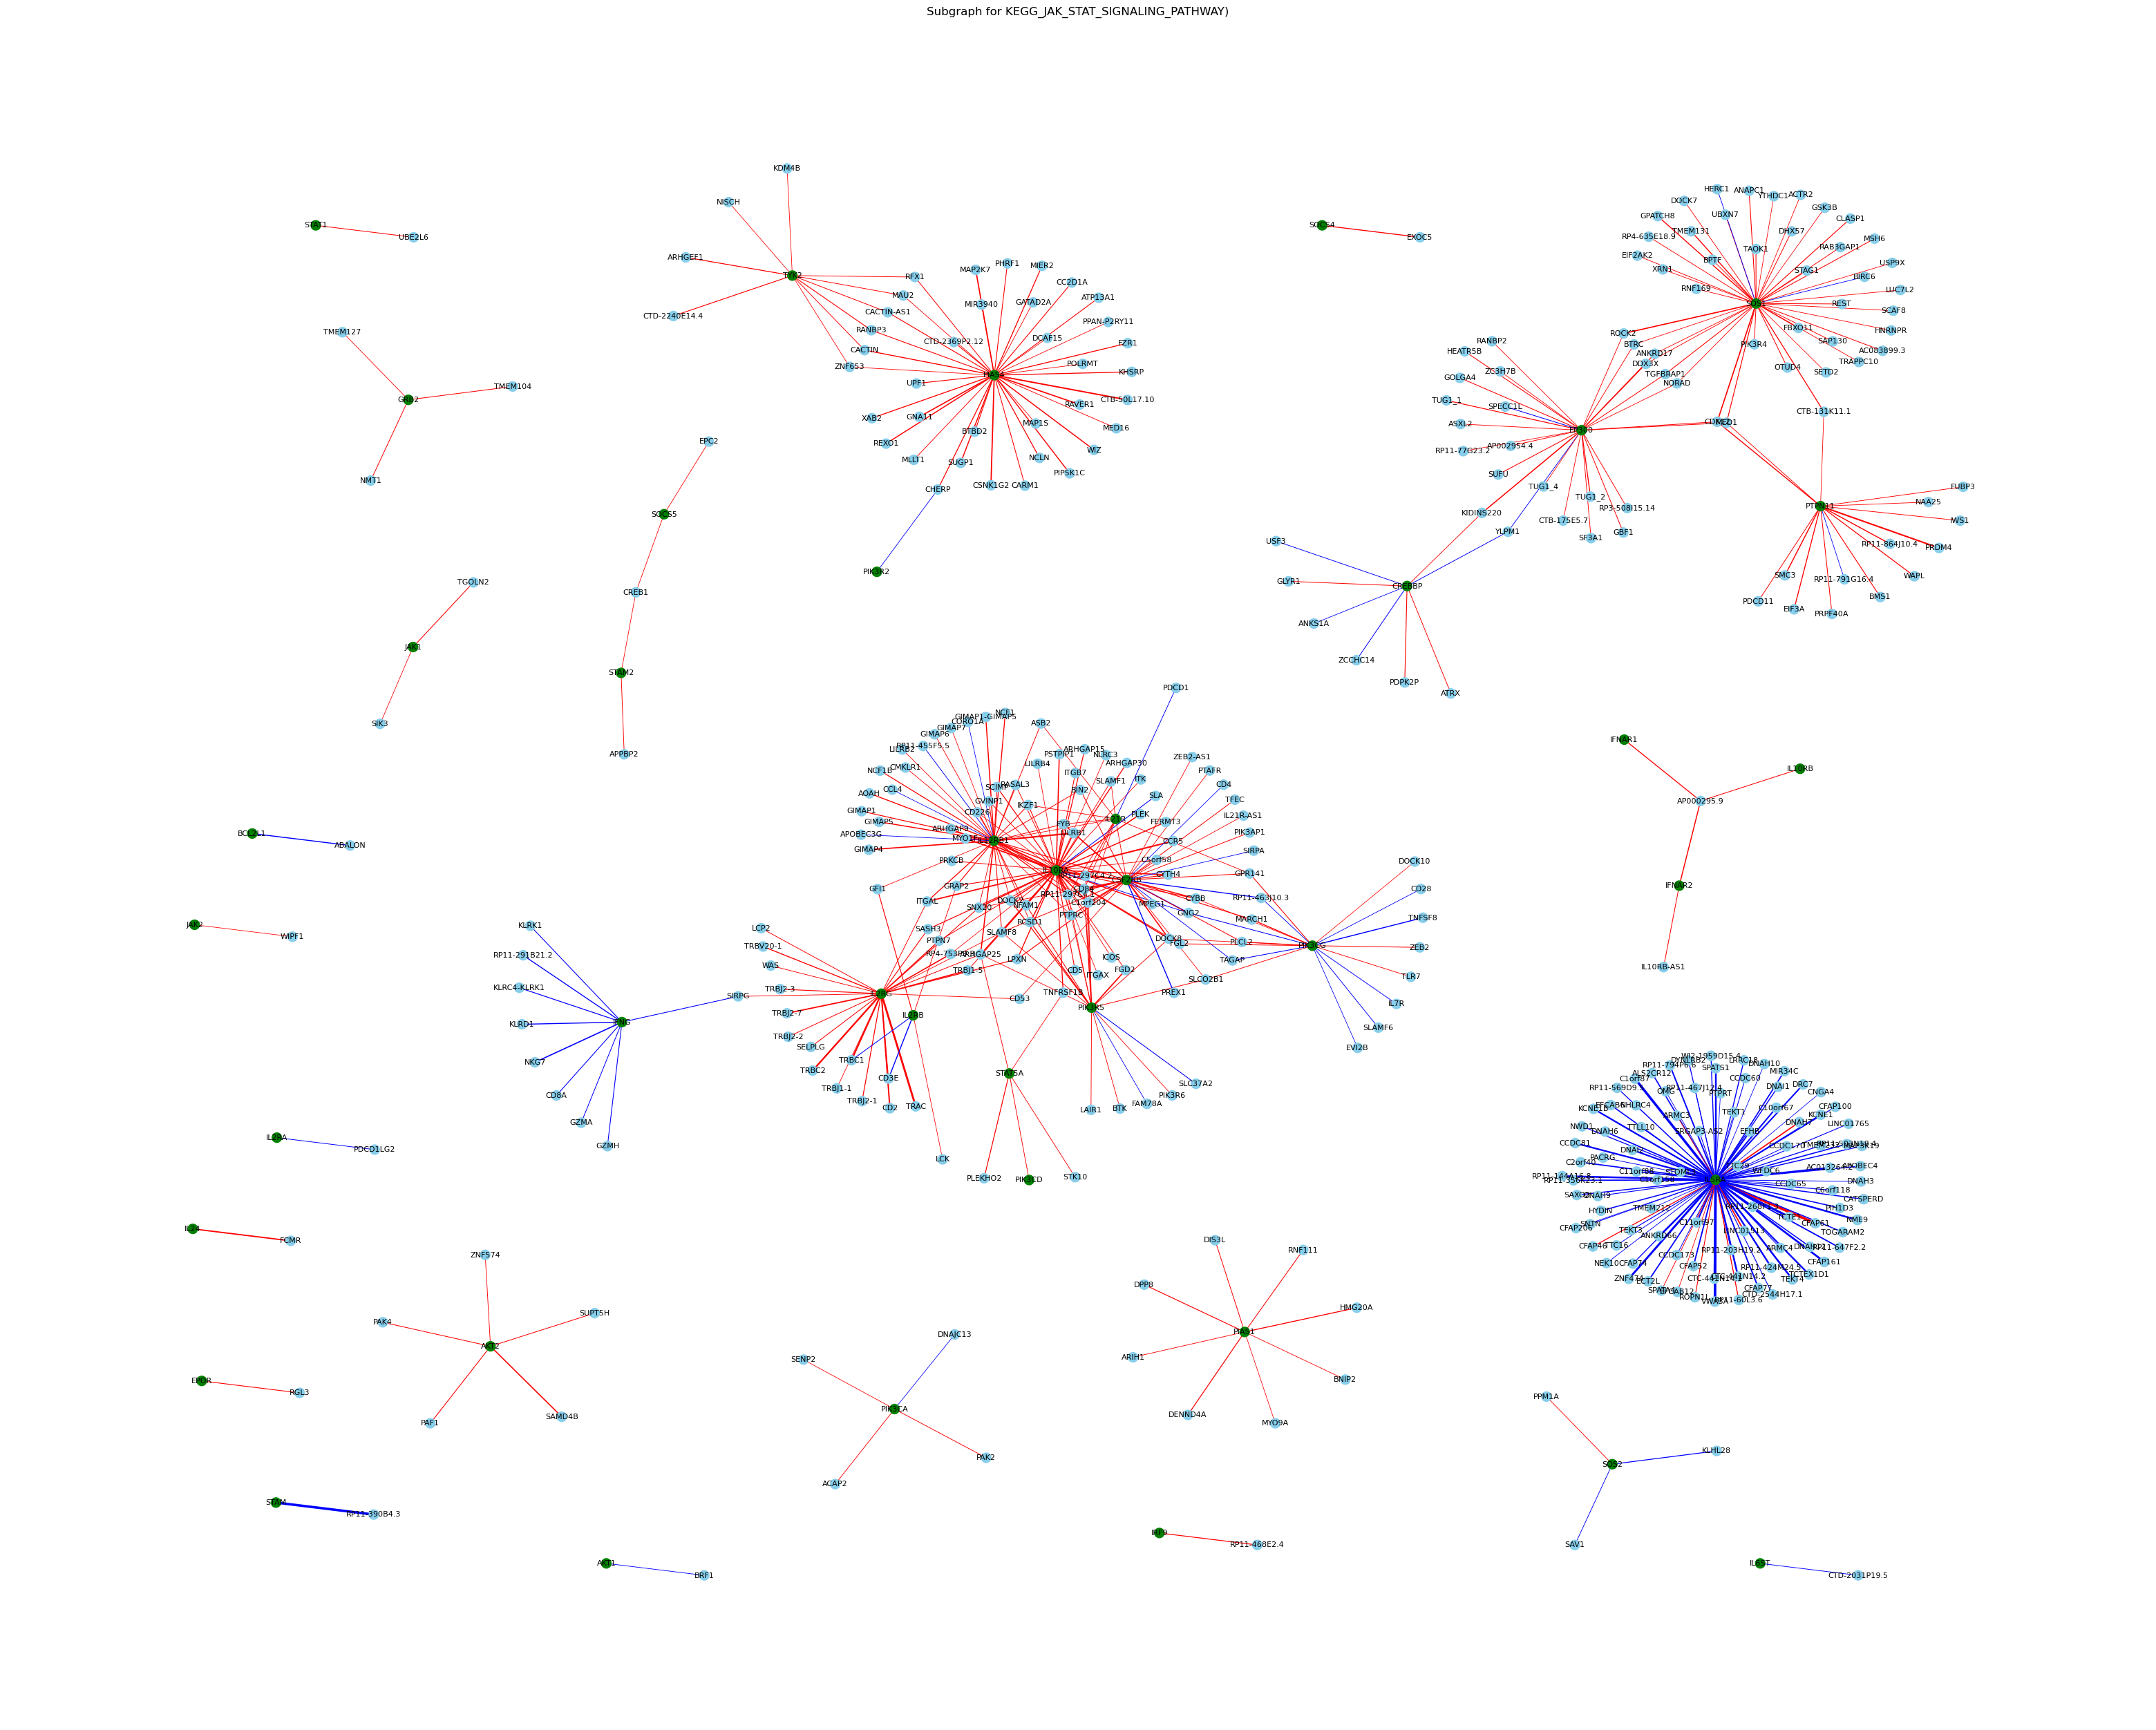

In [16]:
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt

gsea_res_pd = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/LUAD_WGCNA_mVSf_n2v2r_n2v2r_borda_prerank_KEGG_.tsv", sep='\t')
gsea_res_path_leading_genes = gsea_res_pd.loc[gsea_res_pd['pathway'].isin(['KEGG_JAK_STAT_SIGNALING_PATHWAY']),'Lead_genes']

deseq_res_pd = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/luad_mVSf_dif_deseq.txt", sep='\t',index_col=0,header=0)

nodes_to_plot_mapped = []
[nodes_to_plot_mapped.append(x.strip('[]').replace('\'', '').split(', ')) for x in gsea_res_path_leading_genes]
nodes_to_plot_mapped = set(chain(*nodes_to_plot_mapped))


gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}
dif_net = dataloader.graphs[1].subtract(dataloader.graphs[0])
dif_net.index = [ens2symbol[x] for x in dif_net.index]
dif_net.columns = [ens2symbol[x] for x in dif_net.columns]
subgraph_pd = dif_net.loc[nodes_to_plot_mapped, :]


# Convert the adjacency matrix to an edge list
edge_list = subgraph_pd.stack().reset_index()
edge_list.columns = ['Source', 'Target', 'Weight']
edge_list = edge_list[edge_list['Source'] != edge_list['Target']]
edge_list['abs_value'] = edge_list['Weight'].abs()
edge_list = edge_list[edge_list['abs_value'] != 0]


# Sort the DataFrame by the absolute values, then keep the top 100
edge_list_top_neighbors = edge_list.sort_values(by='abs_value', ascending=False).groupby('Source').head(5)
edge_list_top_edges = edge_list.sort_values(by='abs_value', ascending=False).head(500)
edge_list_comb = pd.concat([edge_list_top_neighbors, edge_list_top_edges], ignore_index=True)
edge_list_comb.drop_duplicates()
G = nx.from_pandas_edgelist(edge_list_top_edges, source='Source', target='Target', edge_attr=True)

DeDi_ranking_pd = DeDi_ranking['1'].copy()
DeDi_ranking_pd.index = [ens2symbol[x] if x in ens2symbol else x for x in DeDi_ranking_pd.index ]
deseq_res_pd.index = [ens2symbol[x] if x in ens2symbol else x for x in deseq_res_pd.index ]
for node in G.nodes():
    deg_dif = DeDi_ranking_pd.loc[node,'absDeDi'].max()
    G.nodes[node]['absDeDi'] = float(deg_dif)

    if node in nodes_to_plot_mapped:
        G.nodes[node]['interesting'] = True
    else:
        G.nodes[node]['interesting'] = False

    if node in deseq_res_pd.index:
        G.nodes[node]['padj'] = deseq_res_pd.loc[node,'padj']
        G.nodes[node]['direction'] = deseq_res_pd.loc[node,'sign']
        G.nodes[node]['-logpadj'] = deseq_res_pd.loc[node,'absLogPadj']



# nx.write_graphml(G,'../results/results_gsea/WGCNA_LUAD_mVSf_final/wgcna_mVsf_jakstalead_top500edges_w_dedi_w_deseq.graphml')

fig, ax = plt.subplots(figsize=(40, 32))  # You can adjust the width and height as needed


min_weight = edge_list['Weight'].abs().min()
max_weight = edge_list['Weight'].abs().max()

edge_weights = [10*G[u][v]['abs_value']  for u, v in G.edges]
edge_colors = ['blue' if G[u][v]['Weight'] < 0 else 'red' for u, v in G.edges]

node_colors = ['green' if node in nodes_to_plot_mapped else 'skyblue'  for node in G.nodes]


nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), with_labels=True, node_size=100, node_color=node_colors, edge_color=edge_colors, width=edge_weights, ax=ax,font_size=8)

plt.title("Subgraph for KEGG_JAK_STAT_SIGNALING_PATHWAY)")
plt.show()

In [21]:
#plot the GSEA results from DE analysis with deseq
from node2vec2rank.post_utils import prerank_gseapy


deseq_res = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/luad_mVSf_dif.rnk", sep='\t')

gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}
deseq_res.index = [ens2symbol[x] if x in ens2symbol else x for x in deseq_res.index]

# remove chrY genes for the analysis


chrY_gene_names = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])

deseq_res = deseq_res[~deseq_res.index.isin(chrY_gene_names)]

# run prerank GSEA

save_results = True
do_kegg = True
do_gobp = True
do_reac = True
do_immune = True



# read the geneset libraries
kegg_pathway_fn = '../data/gene_set_libraries/human/c2.cp.kegg.v7.5.1.symbols.gmt'
gobp_pathway_fn = '../data/gene_set_libraries/human/c5.go.bp.v7.5.1.symbols.gmt'
reac_pathway_fn = '../data/gene_set_libraries/human/c2.cp.reactome.v7.5.1.symbols.gmt'
immune_pathway_fn = '../data/gene_set_libraries/human/c7.immunesigdb.v7.5.1.symbols.gmt'


prerank_weight = 0
prerank_min_path_size = 5
prerank_max_path_size = 1500
prerank_num_perms = 1500


if do_kegg:
    deseq_res_pre_KEGG_pd = prerank_gseapy(deseq_res, kegg_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_gobp:
    deseq_res_pre_GOBP_pd = prerank_gseapy(deseq_res, gobp_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_reac:
    deseq_res_pre_REAC_pd = prerank_gseapy(deseq_res, reac_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
    
if do_immune:
    deseq_res_pre_IMMUNE_pd = prerank_gseapy(deseq_res, immune_pathway_fn, prerank_weight=prerank_weight,
                                 prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

if save_results:
    path = '../results/results_gsea/' + gsea_exp_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)


    if do_kegg:
        deseq_res_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                                "_deseq"+"_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
        
    
    if do_gobp:
        deseq_res_pre_GOBP_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_deseq"+"_prerank_GOBP_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

        
    if do_reac:
        deseq_res_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_deseq"+"_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')


    if do_immune:
        deseq_res_pre_IMMUNE_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                             "_deseq"+"_prerank_IMMUNE_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

2023-12-02 18:27:30,397 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-12-02 18:27:30,404 [WARNING] Duplicated values found in preranked stats: 42.90% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-12-02 18:27:33,723 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-12-02 18:27:33,730 [WARNING] Duplicated values found in preranked stats: 42.90% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-12-02 18:29:01,854 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-12-02 18:29:01,861 [WARNING] Duplicated values found in preranked stats: 42.90% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-12-02 18:29:21,421 [WARNING] Input gene rankings contains duplicated IDs, Only use the du

In [24]:
from node2vec2rank.post_utils import plot_gseapy_prerank 

stability_cutoff = 0
padj_cutoff = 0.1

save_directory = '../results/results_gsea/' + gsea_exp_parent_folder_name

if do_kegg:
    title = network_inf_method+ " " +  tissue +  " KEGG prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(deseq_res_pre_KEGG_pd, has_stability=False, characters_trim=40, trim_first_num_characters=5,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="deseq " +title, output_dir=save_directory)

if do_gobp:
    title = network_inf_method+ " " +  tissue +  " GOBP prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(deseq_res_pre_GOBP_pd, has_stability=False, characters_trim=40, trim_first_num_characters=5,padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="deseq " +title, output_dir=save_directory)

if do_reac:
    title = network_inf_method+ " " +  tissue +  " REAC prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(deseq_res_pre_REAC_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="deseq " +title, output_dir=save_directory)

if do_immune:
    title = network_inf_method+ " " +  tissue +  " IMMUNE prerank " + target + " padj " + str(padj_cutoff) + " stab " + str(stability_cutoff)
    plot_gseapy_prerank(deseq_res_pre_IMMUNE_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff, stability_cutoff=stability_cutoff, title="deseq " +title, output_dir=save_directory)
